In [1]:
def AquiferProperties(directoryPath, wellData, DEM, cellSize):
    """
    This function calculates the water table altitude, vadose zone thickness, and standard error of interpolation
    for a given aquifer using Empirical Bayesian Kriging. It also visualizes the results using a folium map.
    
    Parameters:
    directoryPath (str): The path to the directory where the data files are stored.
    wellData (str): Name of the well data points feature class.
    DEM (str): Name of the digital elevation model raster.
    cellSize (float): The size of the grid cells for the spatial analysis.
    
    Returns:
    None
    """

    # Show to the user the limitations for this function
    print(
    """
    This script shows some of the relevant characteristics of an aquifer (water table altitude and vadose zone thickness)
    and creates a geodatabase that contains the layers with this information. As inputs for this code, the user needs to
    supply well points with the depth to water and a Digital Elevation Model (DEM). The output layers are intended to generate
    a quick visualization of the aquifer conditions, but the results should be verified because the code uses a generic
    interpolation model that may not adjust in a valid way to the input data. For this reason, the results for this script
    also include a Standard Error Map that shows the user the accuracy of the interpolation model.
    """)
    
    # Imports necessary libraries for GIS operations, data manipulation, and visualization.
    import arcpy
    from arcpy import env
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import folium
    from folium import TileLayer
    from IPython.display import display
    
    # Sets the ArcPy environment to overwrite outputs and specifies the workspace directory.
    env.overwriteOutput = True
    env.workspace = directoryPath

    # Creates a new file geodatabase to store intermediate and output data.
    arcpy.management.CreateFileGDB(directoryPath, "AquiferProperties.gdb")

    # Analyze the spatial reference for the input layers and reproject if is needed.
    desc_fc = arcpy.Describe(wellData)
    desc_raster = arcpy.Raster(DEM)
    if desc_fc.spatialReference.factoryCode != desc_raster.spatialReference.factoryCode:
        print(f"The coordinate system for the Well data points is: {desc_fc.spatialReference.name} ({desc_fc.spatialReference.factoryCode}) and the coordinate system for the DEM is: {desc_raster.spatialReference.name} ({desc_raster.spatialReference.factoryCode})")
        print("A reprojection is needed for develop this analysis")
        CS = int(input("Enter the EPSG code to project both layers: "))
        arcpy.management.Project(wellData,"AquiferProperties.gdb\\welldData_RP",arcpy.SpatialReference(CS))
        arcpy.management.ProjectRaster(DEM, "AquiferProperties.gdb\\DEM_RP", arcpy.SpatialReference(CS))
        wellData = "AquiferProperties.gdb\\welldData_RP"
        DEM = "AquiferProperties.gdb\\DEM_RP"
        print("-------------------------------------------------------------------------")

    # List the fields in Well data points layer.
    fields = arcpy.ListFields(wellData)
    print(f"The field names in the layer {wellData} are:")
    
    # Print the name for each field in the layer.
    for field in fields:
        print(field.name, end = ", ")

    # Ask the user to enter the field that contains the well depth to water.
    wellDepthField = input("Enter the field that contains the well depth to water: ")

    # Extracts DEM values to the well data points to create a new feature class.
    arcpy.sa.ExtractValuesToPoints(wellData, DEM, "AquiferProperties.gdb\\welldData_v2")
    wellData2 = "AquiferProperties.gdb\\welldData_v2"

    # Adds a new field to store calculated water altitudes.
    arcpy.management.AddFields(wellData2,[["WaterAltitude","DOUBLE","Water altitude"]])

    # Calculates the water altitude by subtracting well depth from DEM values.
    arcpy.CalculateField_management(in_table=wellData2, field= "WaterAltitude",expression= f"!RASTERVALU! - !{wellDepthField}!",expression_type="PYTHON3")

    # Change the working directory to the GDB for perform the interpolation.
    env.workspace = directoryPath + "\\AquiferProperties.gdb"
    
    # Set local variables for the interpolation.
    inPointFeatures = "welldData_v2"
    zField = "WaterAltitude"
    outLayer = "outEBK_GA"
    outRaster = "EBK_predict"
    transformation = "NONE"
    maxLocalPoints = 30
    overlapFactor = 0.5
    numberSemivariograms = 100
    
    # Set variables for search neighborhood.
    radius = 50000
    smooth = 0.4
    searchNeighbourhood = arcpy.SearchNeighborhoodSmoothCircular(radius, smooth)
    outputType = "PREDICTION"
    quantileValue = ""
    thresholdType = ""
    probabilityThreshold = ""
    semivariogram = "POWER"
    
    # Execute Empirical Bayesian Kriging for calculate the prediction.
    arcpy.EmpiricalBayesianKriging_ga(inPointFeatures, zField, outLayer, outRaster,
                                      cellSize, transformation, maxLocalPoints, overlapFactor, numberSemivariograms,
                                      searchNeighbourhood, outputType, quantileValue, thresholdType, probabilityThreshold,
                                      semivariogram)

    # Execute Empirical Bayesian Kriging for calculate the prediction standard error.
    outRaster = "EBK_SE"
    outputType = "PREDICTION_STANDARD_ERROR"
    arcpy.EmpiricalBayesianKriging_ga(inPointFeatures, zField, outLayer, outRaster,
                                      cellSize, transformation, maxLocalPoints, overlapFactor, numberSemivariograms,
                                      searchNeighbourhood, outputType, quantileValue, thresholdType, probabilityThreshold,
                                      semivariogram)

    # Return the working directory to the original route.
    env.workspace = directoryPath

    # Calculates the vadose zone thickness by subtracting the predicted water table altitude from the DEM.
    vzt = arcpy.sa.RasterCalculator([DEM, "AquiferProperties.gdb\\EBK_predict"], ["x", "y"], "x-y", "LastOf", "LastOf")
    vzt.save(directoryPath + "\\AquiferProperties.gdb\\VZT")


    # Creates a Folium map and adds various layers (water table altitude, DEM, well points, standard error, vadose zone thickness) as image overlays.

    #Add the Water table altitude layer to the folium map for create a results visualization
    png_route_wta = directoryPath + "\\WaterTableAltitude.png"

    arcpy.management.ProjectRaster("\\AquiferProperties.gdb\\EBK_predict", "\\AquiferProperties.gdb\\raster_wgs84", arcpy.SpatialReference(4326))
    raster_obj = arcpy.Raster("\\AquiferProperties.gdb\\raster_wgs84")
    
    val_min = raster_obj.minimum
    val_max = raster_obj.maximum
    array_raster = arcpy.RasterToNumPyArray(raster_obj)
    masked_array = np.ma.masked_where(array_raster == raster_obj.noDataValue, array_raster)
    
    colors = plt.cm.terrain(np.linspace(0, 1, 256))
    cmap = ListedColormap(colors)
    
    norm = plt.Normalize(vmin=val_min, vmax=val_max)
    colored_array = cmap(norm(masked_array))
    
    plt.imsave(png_route_wta, colored_array)
    
    extent = raster_obj.extent
    bounds = [[extent.YMin, extent.XMin], [extent.YMax, extent.XMax]]
    
    m = folium.Map(location=[(extent.YMin + extent.YMax) / 2, (extent.XMin + extent.XMax) / 2], zoom_start=7)
    
    folium.raster_layers.ImageOverlay(
        image=png_route_wta,
        bounds=bounds,
        opacity=0.7,
        name="Water Table Altitude"
    ).add_to(m)

    

    # Add the DEM layer to the folium map.
    png_route_dem = directoryPath + "\\dem.png"

    arcpy.management.ProjectRaster(DEM, "\\AquiferProperties.gdb\\raster_wgs84", arcpy.SpatialReference(4326))
    raster_obj = arcpy.Raster("\\AquiferProperties.gdb\\raster_wgs84")
    
    val_min = raster_obj.minimum
    val_max = raster_obj.maximum
    array_raster = arcpy.RasterToNumPyArray(raster_obj)
    masked_array = np.ma.masked_where(array_raster == raster_obj.noDataValue, array_raster)
    
    colors = plt.cm.terrain(np.linspace(0, 1, 256))
    cmap = ListedColormap(colors)
    
    norm = plt.Normalize(vmin=val_min, vmax=val_max)
    colored_array = cmap(norm(masked_array))
    
    plt.imsave(png_route_dem, colored_array)
    
    extent = raster_obj.extent
    bounds = [[extent.YMin, extent.XMin], [extent.YMax, extent.XMax]]
    
    folium.raster_layers.ImageOverlay(
        image=png_route_dem,
        bounds=bounds,
        opacity=0.7,
        name="DEM"
    ).add_to(m)


    # Add the well data points layer to the folium map.
    arcpy.conversion.FeaturesToJSON(wellData2, "WellData.geojson", "FORMATTED", "NO_Z_VALUES", "NO_M_VALUES", "GEOJSON", "WGS84")
    folium.GeoJson(directoryPath + "\\WellData.geojson", name = "Well points", popup = folium.GeoJsonPopup(fields=["WaterDepth"]), tooltip = "Click for details").add_to(m)


    # Add the standard error layer to the folium map.
    png_route_se = directoryPath + "\\InterpolationError.png"

    arcpy.management.ProjectRaster("\\AquiferProperties.gdb\\EBK_SE", "\\AquiferProperties.gdb\\raster_wgs84", arcpy.SpatialReference(4326))
    raster_obj = arcpy.Raster("\\AquiferProperties.gdb\\raster_wgs84")
    
    val_min = raster_obj.minimum
    val_max = raster_obj.maximum
    array_raster = arcpy.RasterToNumPyArray(raster_obj)
    masked_array = np.ma.masked_where(array_raster == raster_obj.noDataValue, array_raster)
    
    colors = plt.cm.bwr(np.linspace(0, 1, 256))
    cmap = ListedColormap(colors)
    
    norm = plt.Normalize(vmin=val_min, vmax=val_max)
    colored_array = cmap(norm(masked_array))
    
    plt.imsave(png_route_se, colored_array)
    
    extent = raster_obj.extent
    bounds = [[extent.YMin, extent.XMin], [extent.YMax, extent.XMax]]
    
    
    folium.raster_layers.ImageOverlay(
        image=png_route_se,
        bounds=bounds,
        opacity=0.7,
        name="Interpolation standard error"
    ).add_to(m)


    
    # Add the Vadose Zone Thickness layer to the folium map.
    png_route_vzt = directoryPath + "\\Vadose Zone Thickness.png"
    arcpy.management.ProjectRaster("\\AquiferProperties.gdb\\VZT", "\\AquiferProperties.gdb\\raster_wgs84", arcpy.SpatialReference(4326))
    raster_obj = arcpy.Raster("\\AquiferProperties.gdb\\raster_wgs84")
    array_raster = arcpy.RasterToNumPyArray(raster_obj)
    masked_array = np.ma.masked_where(array_raster == raster_obj.noDataValue, array_raster)
    
    ranks = [-0.1, 0, 3, 5, 10, 15, 20, 30, 50, 100] 
    colors = ["#000000", "#f7fcfd", "#e0ecf4", "#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#88419d", "#810f7c", "#4d004b"]
    cmap = ListedColormap(colors)
    
    ranks_array = np.digitize(masked_array, ranks, right=True) - 1
    colored_array = cmap(ranks_array)
    
    plt.imsave(png_route_vzt, colored_array)
    
    extent = raster_obj.extent
    bounds = [[extent.YMin, extent.XMin], [extent.YMax, extent.XMax]]
    
    folium.raster_layers.ImageOverlay(
        image=png_route_vzt,
        bounds=bounds,
        opacity=0.7,
        name="Vadose Zone Thickness"
    ).add_to(m)


    # Add the layers legend to the folium map.
    legend_html_vzt = """
     <div style="position: fixed; 
                 bottom: 0px; left: 0px; width: 150px; height: auto; 
                 border:2px solid grey; background-color: white; z-index:9999;
                 font-size:14px;">
     &nbsp; <b>Vadose Zone Thickness</b> <br>
     """

    for i in range(len(ranks) - 1):
        legend_html_vzt += f'&nbsp; <i style="background-color:{colors[i]}; width: 30px; height: 20px; display: inline-block;"></i> {ranks[i]:.1f} - {ranks[i + 1]:.1f} <br>'
    
    legend_html_vzt += "</div>"
    
    
    # Water Table Altitude legend.
    legend_html_wta = """
         <div style="position: fixed; 
                     bottom: 0px; left: 150px; width: 150px; height: auto; 
                     border:2px solid grey; background-color: white; z-index:9999;
                     font-size:14px;">
         &nbsp; <b>Water Table Altitude (masl)</b> <br>
         """
    
    num_colors = 9 
    for i in range(num_colors):
        color = plt.cm.terrain(i / num_colors)
        legend_html_wta += f'&nbsp; <i style="background-color:rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)}); width: 30px; height: 20px; display: inline-block;"></i> {val_min + i * (val_max - val_min) / num_colors:.1f} - {val_min + (i + 1) * (val_max - val_min) / num_colors:.1f} <br>'
    
    legend_html_wta += "</div>"
    
    
    # DEM legend.
    legend_html_dem = """
         <div style="position: fixed; 
                     bottom: 0px; left: 300px; width: 150px; height: auto; 
                     border:2px solid grey; background-color: white; z-index:9999;
                     font-size:14px;">
         &nbsp; <b>DEM (masl)</b> <br>
         """
    
    num_colors = 9 
    for i in range(num_colors):
        color = plt.cm.terrain(i / num_colors)
        legend_html_dem += f'&nbsp; <i style="background-color:rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)}); width: 30px; height: 20px; display: inline-block;"></i> {val_min + i * (val_max - val_min) / num_colors:.1f} - {val_min + (i + 1) * (val_max - val_min) / num_colors:.1f} <br>'
    
    
    legend_html_dem += "</div>"
    
    
    
    # Standard error legend.
    legend_html_se = """
         <div style="position: fixed; 
                     bottom: 0px; left: 450px; width: 150px; height: auto; 
                     border:2px solid grey; background-color: white; z-index:9999;
                     font-size:14px;">
         &nbsp; <b>Standard error</b> <br>
         """
    
    num_colors = 9 
    for i in range(num_colors):
        color = plt.cm.bwr(i / num_colors)
        legend_html_se += f'&nbsp; <i style="background-color:rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)}); width: 30px; height: 20px; display: inline-block;"></i> {val_min + i * (val_max - val_min) / num_colors:.1f} - {val_min + (i + 1) * (val_max - val_min) / num_colors:.1f} <br>'
    
    legend_html_se += "</div>"


    m.get_root().html.add_child(folium.Element(legend_html_vzt))
    m.get_root().html.add_child(folium.Element(legend_html_wta))
    m.get_root().html.add_child(folium.Element(legend_html_dem))
    m.get_root().html.add_child(folium.Element(legend_html_se))

    
    # Add additional base maps to the folium map.
    TileLayer("CartoDB positron", name="CartoDB Positron").add_to(m)  
    TileLayer("CartoDB dark_matter", name="CartoDB Dark Matter").add_to(m) 
    folium.LayerControl().add_to(m)

    #Display the folium map
    display(m)


    # Delete temporary data.
    arcpy.management.Delete("dem.png")
    arcpy.management.Delete("InterpolationError.png")
    arcpy.management.Delete("Vadose Zone Thickness.png")
    arcpy.management.Delete("WaterTableAltitude.png")
    arcpy.management.Delete("\\AquiferProperties.gdb\\raster_wgs84")
    os.remove(directoryPath + "\\WellData.geojson")

    return m

### Function test


    This script shows some of the relevant characteristics of an aquifer (water table altitude and vadose zone thickness)
    and creates a geodatabase that contains the layers with this information. As inputs for this code, the user needs to
    supply well points with the depth to water and a Digital Elevation Model (DEM). The output layers are intended to generate
    a quick visualization of the aquifer conditions, but the results should be verified because the code uses a generic
    interpolation model that may not adjust in a valid way to the input data. For this reason, the results for this script
    also include a Standard Error Map that shows the user the accuracy of the interpolation model.
    
The coordinate system for the Well data points is: Albers_NHG (0) and the coordinate system for the DEM is: GCS_North_American_1983 (4269)
A reprojection is needed for develop this analysis


Enter the EPSG code to project both layers:  102003


-------------------------------------------------------------------------
The field names in the layer AquiferProperties.gdb\welldData_RP are:
OBJECTID, Shape, SITE_BADGE, LAT_DD, LONG_DD, LL_DATUM, LL_ACY_CD, LL_METH_CD, ALT_VA, ALT_DATUM, ALT_METHCD, ALT_ACY_VA, ALT_88, URL, NAT_AQFR, STATION_NM, LANDNET, FIPS_ST, MAP_REGION, WELL_DEPTH, LEVCNT2018, DRYCNT2018, FLOCNT2018, WLA88_2018, D2W_2018, DATE_2018, USE_2018, USECMT2018, X_AlbWGS84, Y_ALBWGS84, Meas_type, MeasCat, FIPS_CNTY, CNTY_NAME, WaterDepth, 

Enter the field that contains the well depth to water:  WaterDepth


C:\Users\lvllsrcs\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N



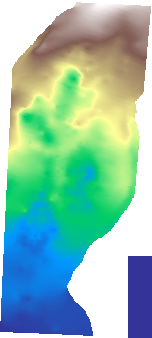
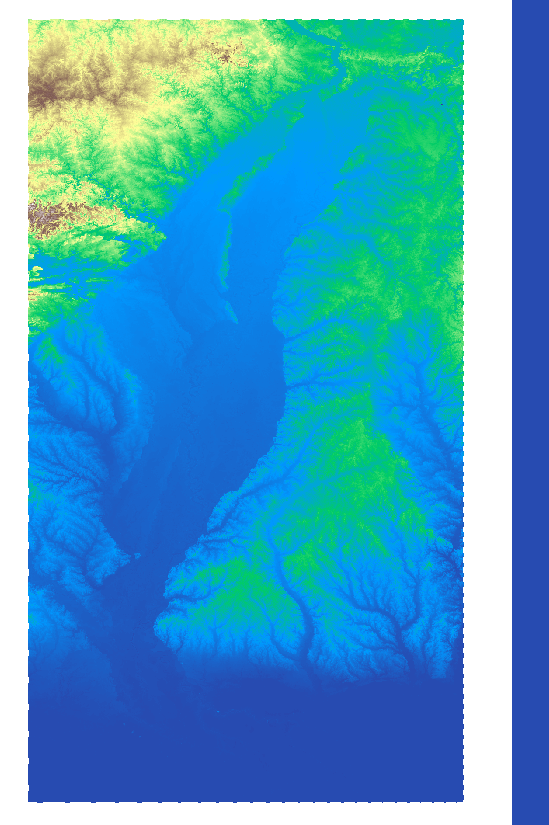
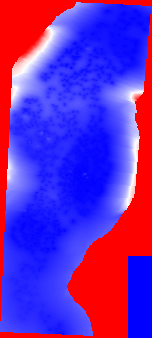
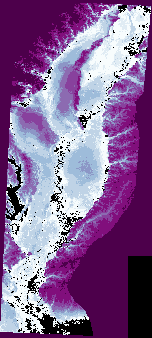

In [2]:
directory = r"C:\Users\lvllsrcs\OneDrive - The University of Memphis\1st Semester\Advance GIS\Project\Layers"
wellPoints = "MRVA_GW_AgencyMeas_2018.shp"
dem = "DEM_v3.tif"
cell_size = 2000

mymap = AquiferProperties(directory, wellPoints, dem, cell_size)
mymap.save(directory + "\\mymap.html")